In [1]:
import os,sys
sys.path.append('./PTS')

import numpy as np
from run_skirt import get_lightcurve
from astropy import units as u
from astropy import constants as c
from scipy import optimize as opt
import datetime
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [2]:
# Define Target and Folders

target = 'ASASSN-15lh'
distance = 1171*u.Mpc
peak = 57250

lightcurve = True

today = str(datetime.date.today())
DATAFILES = "data/"+target+'/'
OUTFILES = "results/"+target+'/'+today+'/'
PLOTFILES = "plots/"+target+'/'+today+'/'
if os.path.isdir(DATAFILES) == False:
    os.makedirs(DATAFILES[:-1])
if os.path.isdir(OUTFILES) == False:
    os.makedirs(OUTFILES[:-1])
if os.path.isdir(PLOTFILES) == False:
    os.makedirs(PLOTFILES[:-1])
log=open(OUTFILES+'log.txt','a')

In [3]:
# Define Simulation Parameters

timesteps = 10         # amount of timesteps considered by SKIRT
output_tsteps = 100    # desired amount of timesteps after interpolation

amin = 1e-4            # smallest dust grain size in micron, this is the lowest value supported by SKIRT
amax = 1               # largest dust grain size in micron
grainpowerlaw = 3      # the powerlaw distribution of mass along different grain sizes
alpha = 1              # radial dust mass density powerlaw
total_mass = 10         # of the dust in MSun
Si = 0.                # silicates fraction (as opposed to graphites)
Lbol_factor = 0.05       # bolometric correction factor

centralBin = 0.01      # size of central grid section in pc
outer = 5              # outer radius of the dust shell in pc
spaceBins = 100        # number of spatial shells in the radial direction

In [4]:
# Load the TDE lightcurve
L=np.genfromtxt(DATAFILES+target+'_lc_neutral.dat',skip_header=1).T[0:3]
W1=np.genfromtxt(DATAFILES+target+'_WISEproc.txt',skip_header=1)[:3]
W2=np.genfromtxt(DATAFILES+target+'_WISEproc.txt',skip_header=1)[3:]

# Central wavelength for the 2 WISE filters
wl_w1=3.368*u.um
wl_w2=4.618*u.um

# Reduce the amount of timesteps to 'timesteps', with a number of them concenrated close to the peak
# if timesteps is increased, users might want to omit this
t_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                       np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))
L_data=binning(t_data,L[0],L[1],L[2])
t_data=L_data[0]

# We will use a constant temperature of 2e4 K here, 
# as our data set does not provide a very accurate read on the TDE's temperature evolution
T_data = np.array((L_data[0],[2e4]*len(L_data[2])))

output_t=np.linspace(np.min(t_data),np.max(np.concatenate([W1[0],W2[0]])),output_tsteps)

output_wavelengths = [3.368, 4.618, 2] # [min_wavelength, max_wavelength, number of bins]

27/01/2024 11:25:07.625 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
27/01/2024 11:25:07.625 !   return _methods._mean(a, axis=axis, dtype=dtype,
27/01/2024 11:25:07.626 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
27/01/2024 11:25:07.626 !   ret = ret.dtype.type(ret / rcount)
27/01/2024 11:25:07.626 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
27/01/2024 11:25:07.626 !   ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
27/01/2024 11:25:07.627 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
27/01/2024 11:25:07.627 !   arrmean = um.true_divide(arrmean, div, out=arrmean,
27/01/2024 11:25:07.628 

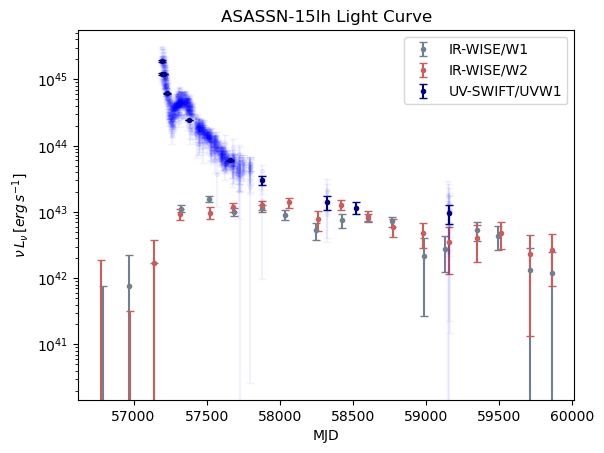

In [5]:
# Plotting the input data
if lightcurve:
    plt.figure()
    plt.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=np.abs((c.c/wl_w1).to(u.Hz).value*W1[2]),\
                 fmt='.',capsize=3,color='slategrey',label='IR-WISE/W1')
    plt.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=np.abs((c.c/wl_w2).to(u.Hz).value*W2[2]),\
                 fmt='.',capsize=3,color='indianred',label='IR-WISE/W2')
    plt.errorbar(L[0],L[1],yerr=L[2],fmt='.',alpha=0.05,capsize=3,color='blue')
    plt.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
    plt.xlabel('MJD')
    plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$")
    plt.title(target+' Light Curve')
    plt.yscale('log')
    plt.legend()
    plt.savefig(OUTFILES+target+'_lightcurve.pdf')
    plt.show()

FWHM 235.48200450309494


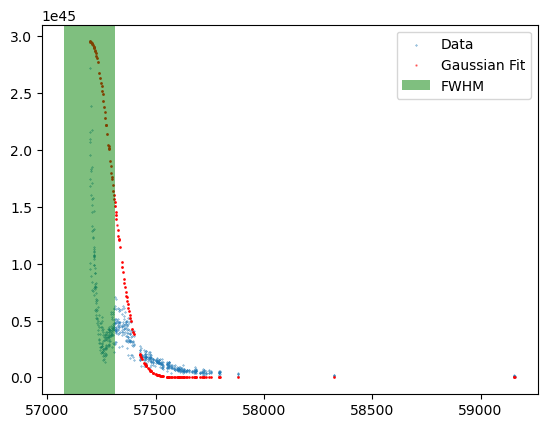

FWHM 41.38972293902923


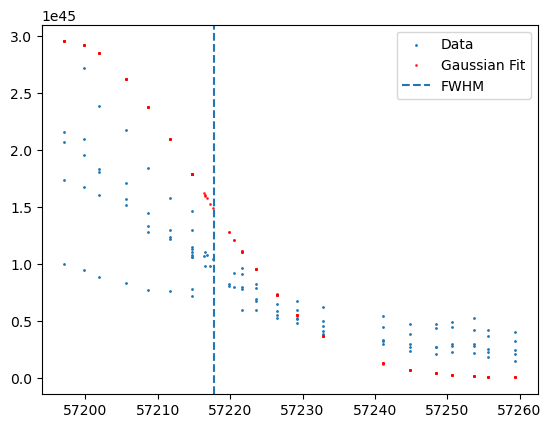

In [6]:
# This implementation cannot track dust survival time
# Therefore dust sublimation is based on the lightcurve's FWHM
# We find this here by fitting a gaussian

def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))
N = len(L[0,:])
X = L[0,:]
Y = L[1,:]

p0 = [L[0,np.argmax(L[1,:])],100] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
fit_mu, fit_stdev = p1
FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print("FWHM", FWHM)

# Plot to verify the fit
plt.figure()
plt.scatter(X,Y,s=0.1,label='Data')
fit=gauss(X,p1)
plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=0.5,alpha=0.5, color='r',label='Gaussian Fit')
plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.5,label='FWHM')
plt.legend()
plt.savefig(OUTFILES+'FWHM.pdf')
plt.show()


# Looking at the first plot shows that the second peak in 15lh's lightcurve is dictating the FWHM
# As this is undesirable, we will not use this part for the fit
def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

mask = (L[0]<57260)
N = len(L[0,mask])
X = L[0,mask]
Y = L[1,mask]

p0 = [L[0,np.argmax(L[1,:])],L[0,np.argmin(np.abs(L[1]-0.5*np.max(L[1])))]-L[0,np.argmax(L[1,:])]] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
fit_mu, fit_stdev = p1
FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print("FWHM", FWHM)

# Plot to verify the fit
plt.figure()
plt.scatter(X,Y,s=1,label='Data')
fit=gauss(X,p1)
plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=1,alpha=0.75, color='r',label='Gaussian Fit')
#plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.25,label='FWHM')
plt.axvline(fit_mu+FWHM/2, label='FWHM', linestyle='dashed')
plt.legend()
plt.savefig(OUTFILES+'FWHM.pdf')
plt.show()

In [7]:
# Start the run
if Si!=False:
    print('x')
    lightcurve,wavelengths,temp,radius,simulation = get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor\
                                                                ,L_data[2]*Lbol_factor))\
                                                      ,T_data,t_data,output_t,\
                                                      [centralBin,outer,alpha,total_mass],\
                                                      [amin,amax,grainpowerlaw],FWHM,spaceBins \
                                                      ,output_wavelengths=output_wavelengths,distance=distance,\
                                                      skiname='TDE_C+Si.ski',Si=Si,prefix=str(today),\
                                                      OUTFILES=OUTFILES,plot_SED=False,SKIRTpath='SKIRT/release/SKIRT/main/skirt')
else:
    lightcurve,wavelengths,temp,radius,simulation = get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                ,L_data[2]*Lbol_factor)) \
                                                      ,T_data,t_data,output_t \
                                                      ,[centralBin,outer,alpha,total_mass] \
                                                      ,[amin,amax,grainpowerlaw],FWHM,spaceBins \
                                                      ,output_wavelengths=output_wavelengths,distance=distance \
                                                      ,skiname='TDE.ski',Si=Si,prefix=str(today) \
                                                      ,OUTFILES=OUTFILES,plot_SED=False,SKIRTpath='SKIRT/release/SKIRT/main/skirt')

SKIRT Runs:   0%|          | 0/10 [00:00<?, ?it/s]

27/01/2024 11:25:09.343   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:25:09.343   Running on remon-lenovo for remon
27/01/2024 11:25:09.343   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/57197/run.ski'...
27/01/2024 11:25:15.405 - Finished setup in 6.0 s.
27/01/2024 11:25:15.549 - Finished setup output in 0.1 s.
27/01/2024 11:25:18.728 - Finished primary emission iteration 1 in 3.2 s.
27/01/2024 11:25:21.935 - Finished primary emission iteration 2 in 3.2 s.
27/01/2024 11:25:25.151 - Finished primary emission iteration 3 in 3.2 s.
27/01/2024 11:25:28.396 - Finished primary emission iteration 4 in 3.2 s.
27/01/2024 11:25:31.528 - Finished primary emission iteration 5 in 3.1 s.
27/01/2024 11:25:34.657 - Finished primary emission iteration 6 in 3.1 s.
27/01/2024 11:25:37.874 - Finished primary emission iteration 7 in 3.2 s.
27/01/2024 11:25:41.027 - Finished primary emission iteration 8 in 3.2 s.
27/01/202

SKIRT Runs:  10%|█         | 1/10 [01:22<12:23, 82.56s/it]

27/01/2024 11:26:31.802 - Finished final output in 7.0 s.
27/01/2024 11:26:31.802 - Finished simulation run using 8 threads and a single process in 82 s (1m 22s).
27/01/2024 11:26:31.815   Available memory: 7.53 GB -- Peak memory usage: 200 MB (2.6%)
27/01/2024 11:26:31.927   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:26:31.927   Running on remon-lenovo for remon
27/01/2024 11:26:31.927   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/57197/run.ski'...
27/01/2024 11:26:40.176 - Finished setup in 8.1 s.
27/01/2024 11:26:40.380 - Finished setup output in 0.2 s.
27/01/2024 11:26:42.585 - Finished primary emission iteration 1 in 2.2 s.
27/01/2024 11:26:44.734 - Finished primary emission iteration 2 in 2.1 s.
27/01/2024 11:26:46.863 - Finished primary emission iteration 3 in 2.1 s.
27/01/2024 11:26:49.029 - Finished primary emission in 2.2 s.
27/01/2024 11:26:50.604 - Finished secondary emission iteration 1 

SKIRT Runs:  20%|██        | 2/10 [02:02<07:38, 57.30s/it]

27/01/2024 11:27:11.412 - Finished final output in 6.9 s.
27/01/2024 11:27:11.412 - Finished simulation run using 8 threads and a single process in 39.4 s.
27/01/2024 11:27:11.426   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:27:11.550   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:27:11.551   Running on remon-lenovo for remon
27/01/2024 11:27:11.551   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/57208/run.ski'...
27/01/2024 11:27:19.901 - Finished setup in 8.2 s.
27/01/2024 11:27:20.082 - Finished setup output in 0.2 s.
27/01/2024 11:27:22.208 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:27:24.345 - Finished primary emission iteration 2 in 2.1 s.
27/01/2024 11:27:26.816 - Finished primary emission in 2.5 s.
27/01/2024 11:27:28.378 - Finished secondary emission iteration 1 in 1.6 s.
27/01/2024 11:27:42.381 - Finished secondary emission in 14.0 s.
27/01/

SKIRT Runs:  30%|███       | 3/10 [02:40<05:39, 48.44s/it]

27/01/2024 11:27:49.309 - Finished final output in 6.9 s.
27/01/2024 11:27:49.309 - Finished simulation run using 8 threads and a single process in 37.6 s.
27/01/2024 11:27:49.323   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:27:49.445   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:27:49.445   Running on remon-lenovo for remon
27/01/2024 11:27:49.445   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/57225/run.ski'...
27/01/2024 11:27:57.774 - Finished setup in 8.2 s.
27/01/2024 11:27:57.958 - Finished setup output in 0.2 s.
27/01/2024 11:28:00.093 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:28:02.210 - Finished primary emission iteration 2 in 2.1 s.
27/01/2024 11:28:04.370 - Finished primary emission in 2.2 s.
27/01/2024 11:28:06.042 - Finished secondary emission iteration 1 in 1.7 s.
27/01/2024 11:28:20.108 - Finished secondary emission in 14.1 s.
27/01/

SKIRT Runs:  40%|████      | 4/10 [03:17<04:25, 44.20s/it]

27/01/2024 11:28:27.012 - Finished final output in 6.9 s.
27/01/2024 11:28:27.012 - Finished simulation run using 8 threads and a single process in 37.5 s.
27/01/2024 11:28:27.027   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:28:27.124   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:28:27.124   Running on remon-lenovo for remon
27/01/2024 11:28:27.124   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/57378/run.ski'...
27/01/2024 11:28:35.434 - Finished setup in 8.2 s.
27/01/2024 11:28:35.616 - Finished setup output in 0.2 s.
27/01/2024 11:28:37.689 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:28:39.831 - Finished primary emission in 2.1 s.
27/01/2024 11:28:41.474 - Finished secondary emission iteration 1 in 1.6 s.
27/01/2024 11:28:55.896 - Finished secondary emission in 14.4 s.
27/01/2024 11:28:55.896 - Finished the run in 20.3 s.


SKIRT Runs:  50%|█████     | 5/10 [03:53<03:25, 41.17s/it]

27/01/2024 11:29:02.828 - Finished final output in 6.9 s.
27/01/2024 11:29:02.828 - Finished simulation run using 8 threads and a single process in 35.6 s.
27/01/2024 11:29:02.841   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:29:02.927   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:29:02.927   Running on remon-lenovo for remon
27/01/2024 11:29:02.927   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/57659/run.ski'...
27/01/2024 11:29:11.410 - Finished setup in 8.4 s.
27/01/2024 11:29:11.594 - Finished setup output in 0.2 s.
27/01/2024 11:29:13.675 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:29:15.876 - Finished primary emission in 2.2 s.
27/01/2024 11:29:17.548 - Finished secondary emission iteration 1 in 1.7 s.
27/01/2024 11:29:32.122 - Finished secondary emission in 14.6 s.
27/01/2024 11:29:32.122 - Finished the run in 20.5 s.


SKIRT Runs:  60%|██████    | 6/10 [04:29<02:38, 39.52s/it]

27/01/2024 11:29:39.135 - Finished final output in 7.0 s.
27/01/2024 11:29:39.135 - Finished simulation run using 8 threads and a single process in 36.1 s.
27/01/2024 11:29:39.149   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:29:39.258   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:29:39.258   Running on remon-lenovo for remon
27/01/2024 11:29:39.258   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/57881/run.ski'...
27/01/2024 11:29:47.851 - Finished setup in 8.5 s.
27/01/2024 11:29:48.035 - Finished setup output in 0.2 s.
27/01/2024 11:29:50.125 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:29:52.316 - Finished primary emission in 2.2 s.
27/01/2024 11:29:53.979 - Finished secondary emission iteration 1 in 1.7 s.
27/01/2024 11:30:08.406 - Finished secondary emission in 14.4 s.
27/01/2024 11:30:08.406 - Finished the run in 20.4 s.


SKIRT Runs:  70%|███████   | 7/10 [05:06<01:55, 38.59s/it]

27/01/2024 11:30:15.808 - Finished final output in 7.4 s.
27/01/2024 11:30:15.808 - Finished simulation run using 8 threads and a single process in 36.4 s.
27/01/2024 11:30:15.822   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:30:15.926   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:30:15.926   Running on remon-lenovo for remon
27/01/2024 11:30:15.926   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/58324/run.ski'...
27/01/2024 11:30:24.214 - Finished setup in 8.2 s.
27/01/2024 11:30:24.396 - Finished setup output in 0.2 s.
27/01/2024 11:30:26.498 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:30:28.712 - Finished primary emission in 2.2 s.
27/01/2024 11:30:30.367 - Finished secondary emission iteration 1 in 1.7 s.
27/01/2024 11:30:44.876 - Finished secondary emission in 14.5 s.
27/01/2024 11:30:44.876 - Finished the run in 20.5 s.


SKIRT Runs:  80%|████████  | 8/10 [05:42<01:15, 37.78s/it]

27/01/2024 11:30:51.860 - Finished final output in 7.0 s.
27/01/2024 11:30:51.860 - Finished simulation run using 8 threads and a single process in 35.8 s.
27/01/2024 11:30:51.873   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:30:51.992   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:30:51.993   Running on remon-lenovo for remon
27/01/2024 11:30:51.993   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/58519/run.ski'...
27/01/2024 11:31:00.308 - Finished setup in 8.2 s.
27/01/2024 11:31:00.496 - Finished setup output in 0.2 s.
27/01/2024 11:31:02.596 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:31:04.805 - Finished primary emission in 2.2 s.
27/01/2024 11:31:06.471 - Finished secondary emission iteration 1 in 1.7 s.
27/01/2024 11:31:20.917 - Finished secondary emission in 14.4 s.
27/01/2024 11:31:20.917 - Finished the run in 20.4 s.


SKIRT Runs:  90%|█████████ | 9/10 [06:18<00:37, 37.25s/it]

27/01/2024 11:31:27.930 - Finished final output in 7.0 s.
27/01/2024 11:31:27.930 - Finished simulation run using 8 threads and a single process in 35.8 s.
27/01/2024 11:31:27.944   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)
27/01/2024 11:31:28.066   Welcome to SKIRT v9.0 (git 98aa521 built on 27/01/2024 at 10:59:48)
27/01/2024 11:31:28.066   Running on remon-lenovo for remon
27/01/2024 11:31:28.066   Constructing a simulation from ski file '/home/remon/DREAMT2/results/ASASSN-15lh/2024-01-27/59155/run.ski'...
27/01/2024 11:31:36.388 - Finished setup in 8.2 s.
27/01/2024 11:31:36.574 - Finished setup output in 0.2 s.
27/01/2024 11:31:38.674 - Finished primary emission iteration 1 in 2.1 s.
27/01/2024 11:31:40.863 - Finished primary emission in 2.2 s.
27/01/2024 11:31:42.587 - Finished secondary emission iteration 1 in 1.7 s.
27/01/2024 11:31:57.078 - Finished secondary emission in 14.5 s.
27/01/2024 11:31:57.078 - Finished the run in 20.5 s.


SKIRT Runs: 100%|██████████| 10/10 [06:55<00:00, 41.52s/it]


27/01/2024 11:32:04.378 - Finished final output in 7.3 s.
27/01/2024 11:32:04.378 - Finished simulation run using 8 threads and a single process in 36.2 s.
27/01/2024 11:32:04.393   Available memory: 7.53 GB -- Peak memory usage: 202 MB (2.6%)


100%|██████████| 2/2 [00:00<00:00,  9.37it/s]























In [8]:
# indices corresponding to the WISE filter wavelengths
w1=np.argmin(np.abs(wavelengths-wl_w1.value))
w2=np.argmin(np.abs(wavelengths-wl_w2.value))

# Convert the lightcurve to luminosity
luminosity=FluxtoLum(lightcurve,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used, 
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.
coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
log.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor)+', sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
log.write('\n')
if os.path.isdir(OUTFILES+'GridSearch/')==False:
    os.makedirs(OUTFILES+'GridSearch/')
if os.path.isdir(PLOTFILES+'/')==False:
    os.makedirs(PLOTFILES+'/')

np.savetxt(OUTFILES+'config.txt',luminosity.value)

27/01/2024 11:32:08.338 ! /home/remon/miniconda3/envs/astro/lib/python3.11/site-packages/astropy/units/quantity.py:1708: AstropyWarning: function 'max' is not known to astropy's Quantity. Will run it anyway, hoping it will treat ndarray subclasses correctly. Please raise an issue at https://github.com/astropy/astropy/issues. 
27/01/2024 11:32:08.338 !   warnings.warn("function '{}' is not known to astropy's Quantity. "


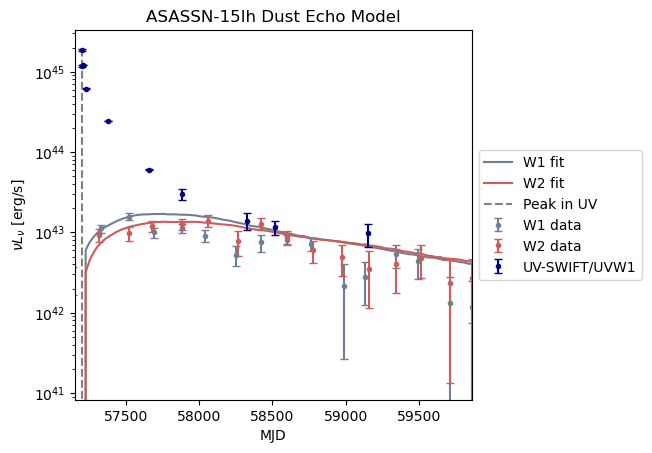

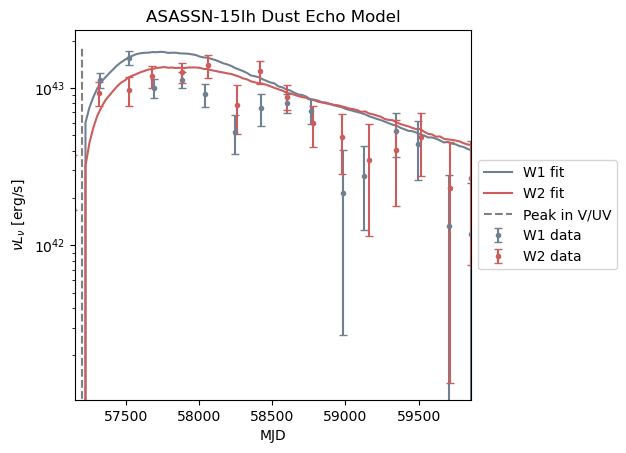

In [9]:
# Apply the covering factor
luminosity = luminosity * coveringFactor

# Plot the lightcurve
fig=plt.figure()
ax=plt.subplot(111)
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred')
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
plt.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
ax.plot([t_data[np.argmax(L_data[1,:])]]*2,ax.get_ylim(),linestyle='dashed',color='grey',label='Peak in UV')
ax.set_yscale('log')
ax.set_xlim(peak-100,np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('MJD')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES+'/lightcurve.pdf')

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred')
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.plot([t_data[np.argmax(L_data[1,:])]]*2,ax.get_ylim(),linestyle='dashed',color='grey',label='Peak in V/UV')
ax.set_yscale('log')
ax.set_xlim(peak-100,np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('MJD')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES+'/lightcurve(1).pdf')